In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import mlflow
import tools
import gc

import warnings
warnings.filterwarnings("ignore")

<h1  style= "background-color: gray;
                 color:white;
            text-align: center; 
            font-family:Helvetica, Arial, verdana, sans-serif"> Experiment Tracking </h1>

## 1. Introduction

### Context

In this project, we are going to build a scoring model aims to compute the probability that a customer will repay his loan... 


In [2]:
# run in the terminal : mlflow server --backend-store-uri sqlite:///mlflow.db
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.autolog() 

2023/04/19 18:55:54 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/19 18:55:56 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


## Part 1 - EDA & Preprocessing

In this section, we will explore and preprocess data using the tools and technics bellow :
- Produce some visualizations to understand data 
- NaN Imputing with simple imputer
- Reduction of dimension with PCA

**Important :**

We are going to start by loading data. Notice that we processed this using the kernel bellow :

https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

Train set: 307511, Test set: 48744
Bureau df shape: (305811, 116)
Previous applications df shape: (338857, 249)
Pos-cash balance df shape: (337252, 18)
Installments payments df shape: (339587, 26)
Credit card balance df shape: (103558, 141)

 ************************* infos ************************* 

Nombre de colonnes :  799 

Nombre de lignes :  307511 



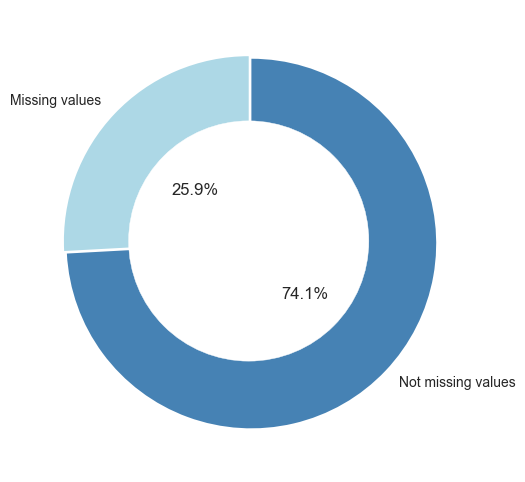

Nombre total de valeurs manquantes :  63544275 



In [4]:
# Load preprocessed data using 
data = tools.main()
pickle.dump(data, open('../data/raw_data.pkl', 'wb'))
data_na = data[data['TARGET'].isna()].set_index('SK_ID_CURR')
data = data[data['TARGET'].notnull()].set_index('SK_ID_CURR')
print('\n','*'*25, 'infos', '*'*25,'\n')
tools.describe_data(data)
pickle.dump(data, open('../data/data.pkl', 'wb'))


### Data Exploring

Here are few transformations comes with the kernel used to prepare data...


In [5]:
import joblib
raw_data = joblib.load('../data/raw_data.pkl')
raw_data.columns

Index(['index', 'SK_ID_CURR', 'TARGET', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=800)

In [6]:
[elem for elem in raw_data.columns if 'SEX' in elem]

[]

************************* Anomalies on DAYS_EMPLOYED set to NaN *************************


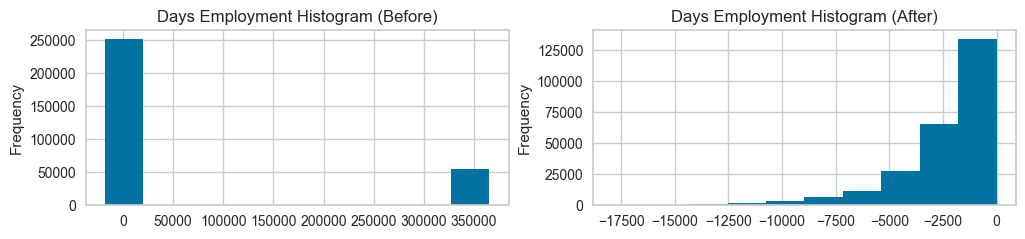

************************* New features are computed *************************


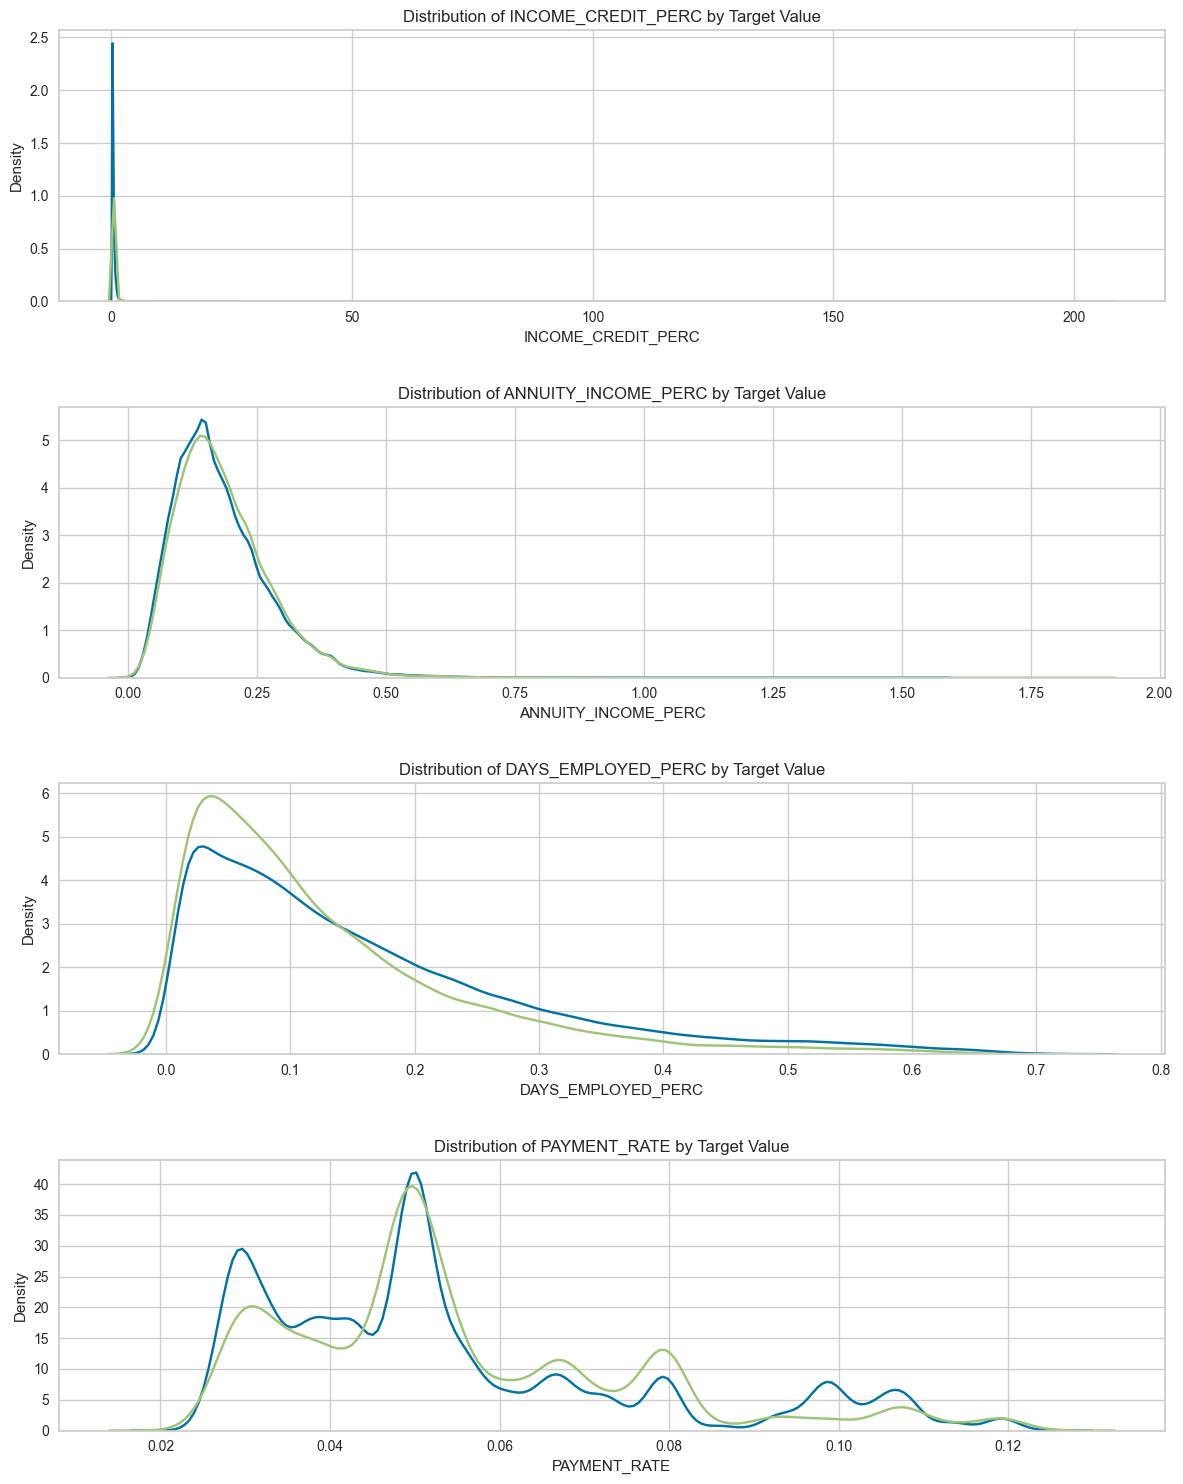

In [7]:
# Anomalies on DAYS_EMPLOYED column
app_train = pd.read_csv('../data/application_train.csv')
print('*'*25, 'Anomalies on DAYS_EMPLOYED set to NaN' , '*'*25)
plt.figure(figsize = (12, 5))
plt.subplot(221)
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram (Before)')
plt.subplot(222)
data['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram (After)')
plt.show()

print('*'*25, 'New features are computed' , '*'*25)

plt.figure(figsize = (12, 15))
# iterate through the new features
for i, feature in enumerate(['INCOME_CREDIT_PERC', 'ANNUITY_INCOME_PERC', 'DAYS_EMPLOYED_PERC', 'PAYMENT_RATE']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(data.loc[data['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(data.loc[data['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density')
    
plt.tight_layout(h_pad = 2.5)

We will start by defining **target** and **features**

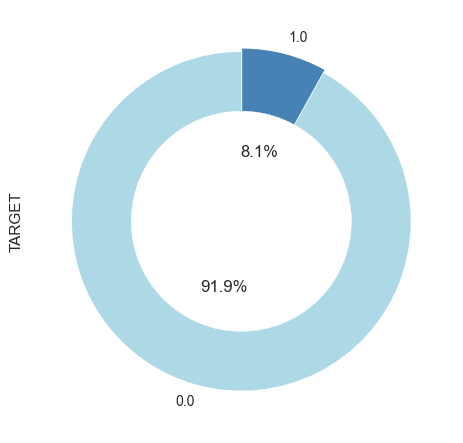

Counter({0.0: 282686, 1.0: 24825})


In [8]:
# set the target
y = data['TARGET']


# set features
X = data[[f for f in data.columns if f not in ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"]]]


# check target
y.value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90,
    explode=(0, 0.02),
    colors=["lightblue", "steelblue"],
    pctdistance=0.4,
    labeldistance=1.1,
)
circle = plt.Circle((0, 0), 0.65, color="white")
p = plt.gcf()
p.gca().add_artist(circle)
plt.show()

print(Counter(y))

**Important**

We can see that we are dealing with **imbalanced data** 

In [9]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET']

# Display correlations
print('*'*25,'Top10 positive correlations','*'*25)
display(correlations.sort_values(ascending=False).head(10))
print('*'*25,'Top10 negative correlations','*'*25)
display(correlations.sort_values().head(10))

************************* Top10 positive correlations *************************


TARGET                         1.000000
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
Name: TARGET, dtype: float64

************************* Top10 negative correlations *************************


EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64

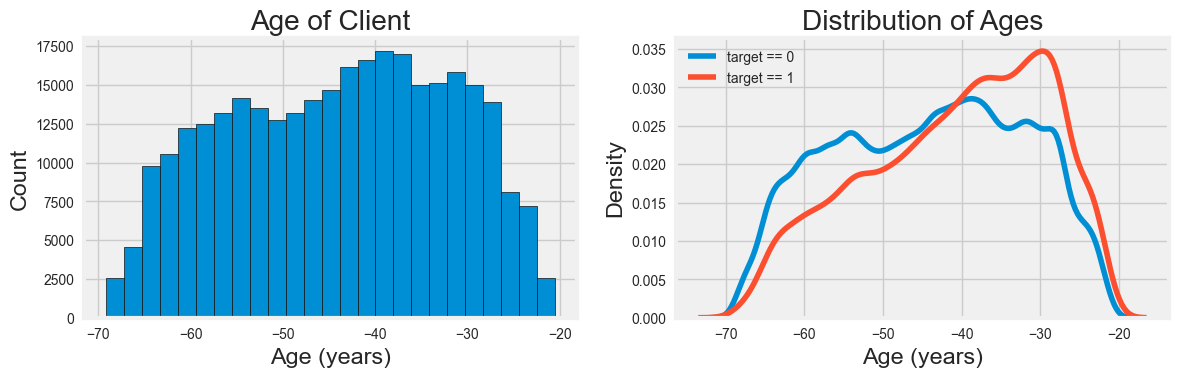

In [10]:
plt.figure(figsize = (14, 8))

# Set the style of plots
plt.style.use('fivethirtyeight')
plt.subplot(221)
# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count')

plt.subplot(222)
# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')
# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')
# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')
plt.legend()
plt.show()

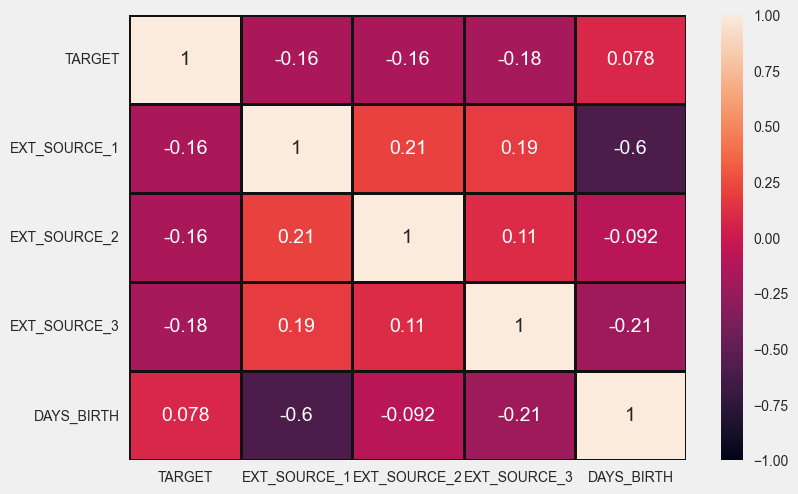

In [11]:
# Extract the EXT_SOURCE variables and show correlations
ext_data_corrs = data[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']].corr()

# Heatmap of correlations
sns.heatmap(ext_data_corrs,  vmin=-1, vmax=1, annot=True, linecolor='k', linewidths=2)
plt.show()

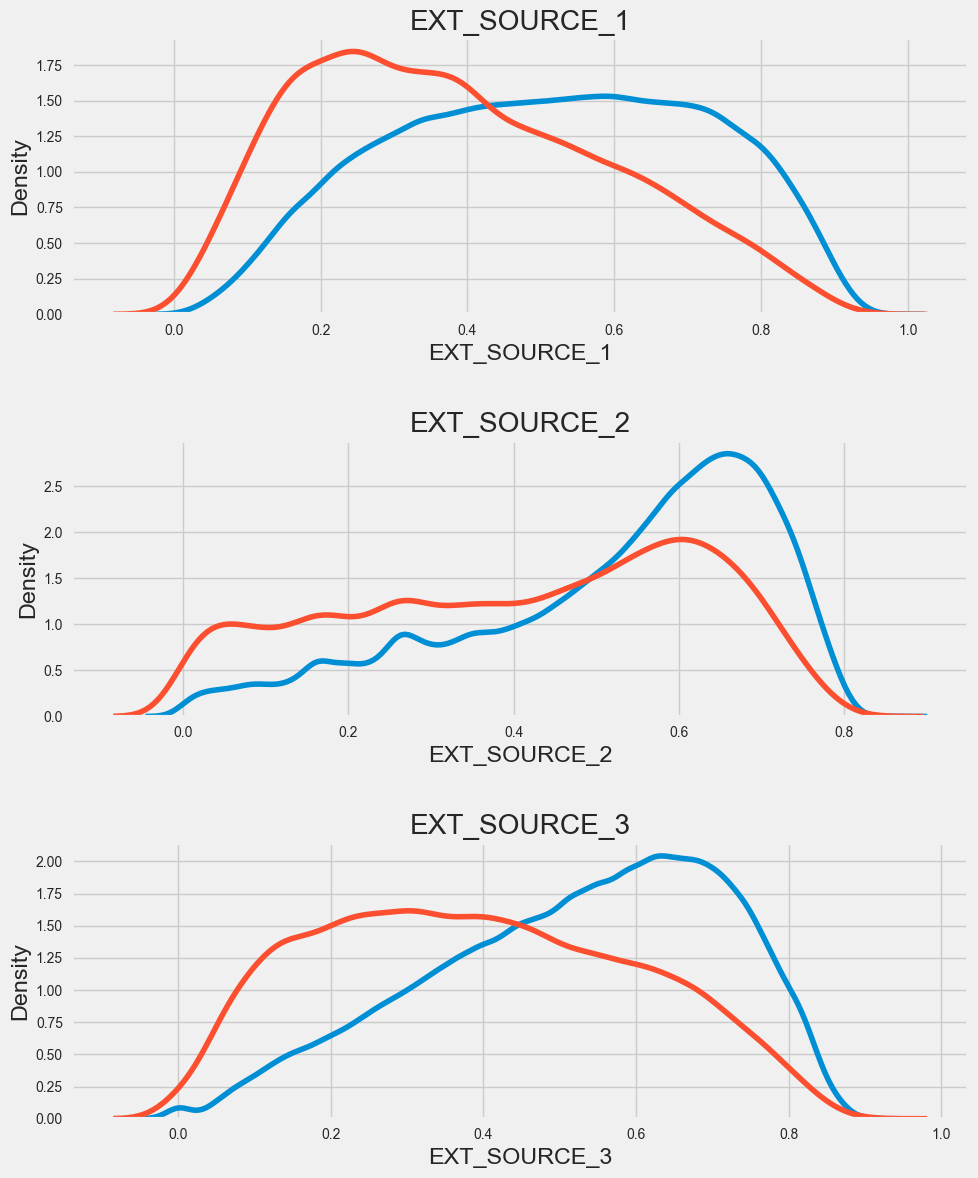

In [12]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('%s' % source)
    #plt.xlabel('%s' % source); plt.ylabel('Density')
    
    plt.tight_layout(h_pad = 2.5)

### NaN Imputing

************************* Describe data *************************


,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,252137.000000,...,86905.000000,86905.000000,86905.000000,86273.00000,86905.0,86905.0,86905.0,86905.0,86273.0,86905.000000
mean,0.340108,0.306327,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,-2384.169325,...,0.049376,0.003738,0.114366,0.00307,0.0,0.0,0.0,0.0,0.0,37.143605
std,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,2338.360162,...,0.216653,0.031882,1.323208,0.02036,0.0,0.0,0.0,0.0,0.0,33.698512
min,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,1.000000
25%,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-3175.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,10.000000
50%,0.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1648.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,22.000000
75%,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-767.000000,...,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,75.000000
max,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,0.000000,...,1.000000,1.000000,62.000000,0.50000,0.0,0.0,0.0,0.0,0.0,192.000000


************************* After imputing NaN *************************
Nombre de colonnes :  797 

Nombre de lignes :  307511 



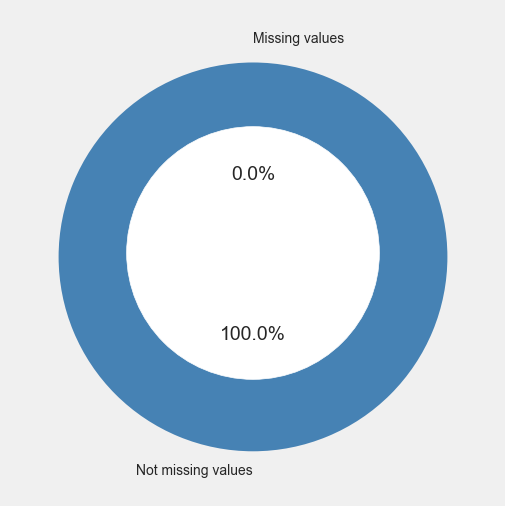

Nombre total de valeurs manquantes :  0 



20770

In [13]:
print('*'*25, 'Describe data', '*'*25)
display(X.describe())

X.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(missing_values=np.nan, strategy="median")
X.iloc[:, :] = imputer.fit_transform(X)
print('*'*25, 'After imputing NaN', '*'*25)
tools.describe_data(X)
gc.collect()

### Scale Data

In [14]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
pickle.dump(X_scaled_df, open('../data/X_scaled_df.pkl', 'wb'))
X_scaled_df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.0,0.0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.888839,0.964437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109948
100003,0.0,1.0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.477114,0.933676,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109948
100004,1.0,0.0,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.348534,0.987439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109948
100006,0.0,0.0,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.350846,0.830337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026178
100007,0.0,0.0,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.298591,0.830393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109948


### Cross validation and splitting

In [15]:
X_train, X_test, y_train, y_test = tools.cross_val_split(X_scaled_df, y)

X_train shape : (276760, 797)
X_test shape : (30751, 797)
y_train shape : (276760,)
y_test shape : (30751,)


### Resampling

In [16]:
# Under sampling
us = RandomUnderSampler(sampling_strategy="majority", random_state=42)
X_under, y_under = us.fit_resample(X_train, y_train)
print("Under sampled dataset shape {}".format(Counter(y_under)))
# export data
pickle.dump(X_under, open('../data/X_under.pkl', 'wb'))
pickle.dump(y_under, open('../data/y_under.pkl', 'wb'))


# Over sampling
os = SMOTE(random_state=42)
X_over, y_over = os.fit_resample(X_train, y_train)
print("Over sampled dataset shape {}".format(Counter(y_over)))
# export data
pickle.dump(X_over, open('../data/X_over.pkl', 'wb'))
pickle.dump(y_over, open('../data/y_over.pkl', 'wb'))


# # hybrid sampling
# hs = SMOTEENN(random_state=42)
# X_hybrid, y_hybrid = hs.fit_resample(X_train, y_train)
# print("hybrid sampled dataset shape {}".format(Counter(y_hybrid)))
# # export data
# pickle.dump(X_hybrid, open('../loan_scoring-data/X_hybrid.pkl', 'wb'))
# pickle.dump(y_hybrid, open('../loan_scoring-data/y_hybrid.pkl', 'wb'))


Under sampled dataset shape Counter({0.0: 22272, 1.0: 22272})


2023/04/19 18:58:27 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/04/19 18:58:27 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2023/04/19 18:58:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ff42bd87295a47bdaaed1a6a972870d3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/04/19 18:58:28 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/04/19 18:58:28 WARNING mlflow.sklearn: Failed to infer model signature: the trai

Over sampled dataset shape Counter({1.0: 254488, 0.0: 254488})


## Part2 - Modeling

In [17]:
from sklearn.metrics import confusion_matrix, make_scorer, roc_curve, auc
from sklearn.model_selection import GridSearchCV


In [39]:
results = pd.DataFrame(columns=["Algorithm", "Balancing_method",
                                "AUC", "AUC_test", "Time"])

Here, we will experiment few models using mlflow. 

Experiment tracking is a process used to track all the relevant information from a machine learning experience which includes :
source code, environment, data, model, hyperpamameters and metrics. 
It is important for basicly 3 reaseons : 
- Reproducibility : as datascientist we experiment a lot of models and need to reproduce the ones with the best paarameters...
- Organization : in case  u work in a team and need versioning and organization
- Optimization : automation help us track metrics and parameters and chose the best ones...
<!-- 
In this section we are going to use mlflow in order to experiment 3 classification algorithms such as :
- Logistic regression
- LightGBM
- XGboost
- -->


**Artifact**  =>  [Click here to read more about Artifacts...](https://h2o.ai/wiki/artifacts/)

**Classifiction reppots metrics**  =>  [More about classification report from sklearn](https://www.jcchouinard.com/classification-report-in-scikit-learn/)

In [40]:
results

,Algorithm,Balancing_method,AUC,AUC_test,Time


### Logistic Regression

2023/04/20 05:30:30 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/20 05:30:56 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/2/6ffda9e5374c4d229471c3f7b147b7fb/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


************************* Test scores - reg_logistic_normal_data *************************
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     28198
         1.0       0.56      0.03      0.06      2553

    accuracy                           0.92     30751
   macro avg       0.74      0.51      0.51     30751
weighted avg       0.89      0.92      0.88     30751



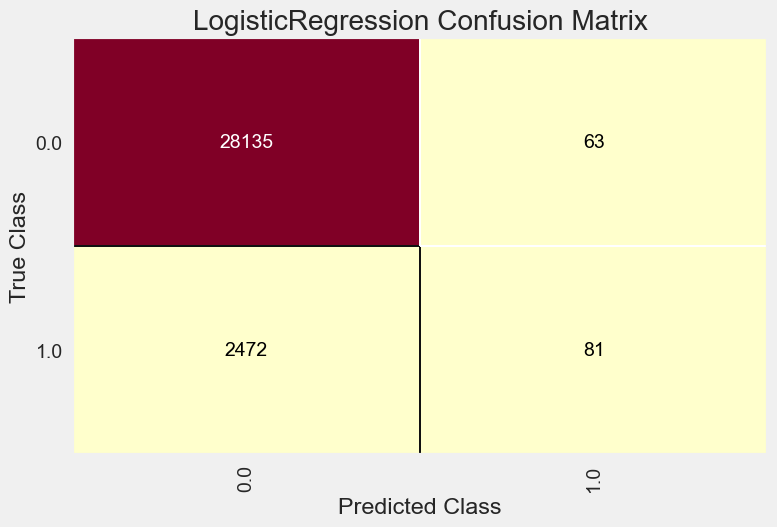

2023/04/20 05:30:56 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/20 05:31:05 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/2/e8d3a8d43cb747f089923f0ff99e9ff9/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


************************* Test scores - reg_logistic_under_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     28198
         1.0       0.17      0.68      0.27      2553

    accuracy                           0.70     30751
   macro avg       0.57      0.69      0.54     30751
weighted avg       0.89      0.70      0.77     30751



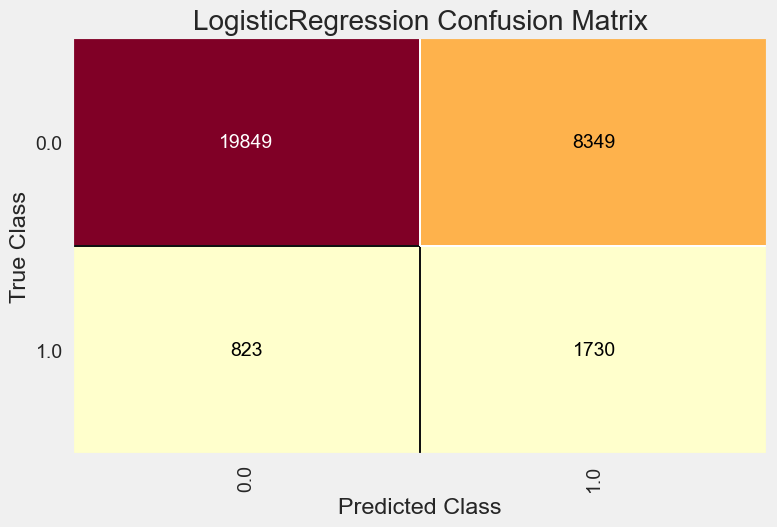

2023/04/20 05:31:05 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/20 05:31:57 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/2/dd85138feb4440b7afe359d7ffcce275/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


************************* Test scores - reg_logistic_over_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82     28198
         1.0       0.17      0.63      0.27      2553

    accuracy                           0.71     30751
   macro avg       0.56      0.67      0.54     30751
weighted avg       0.89      0.71      0.77     30751



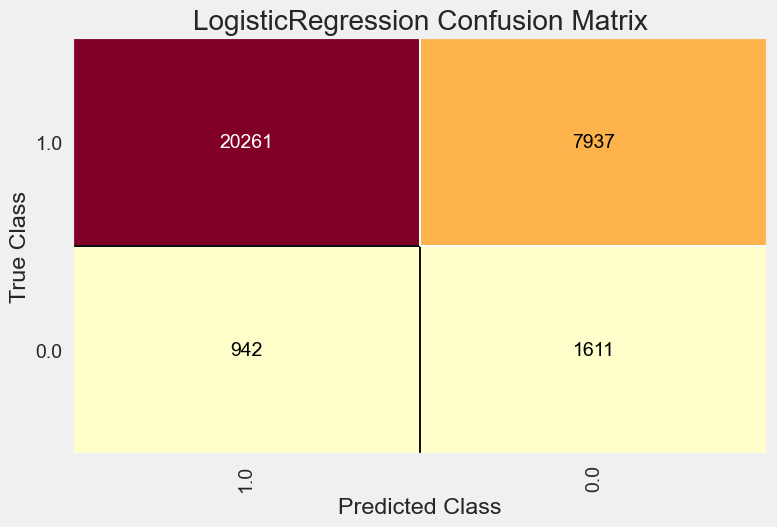

2023/04/20 05:31:58 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/20 05:32:19 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/2/e5640060e49945ca8c7d7aa4ce365281/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


************************* Test scores - reg_logistic_over_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.96      0.71      0.81     28198
         1.0       0.17      0.68      0.28      2553

    accuracy                           0.70     30751
   macro avg       0.57      0.69      0.54     30751
weighted avg       0.90      0.70      0.77     30751



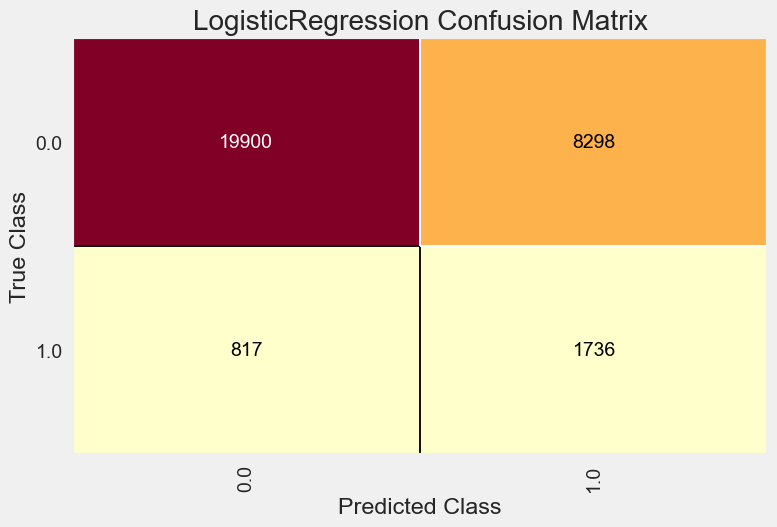

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Original,0.771,0.758,0.000000e+00
1,Baseline,Undersampling,0.775,0.758,9.536743e-07
2,Baseline,Oversampling,0.804,0.741,4.053116e-06
3,Baseline,Balanced,0.773,0.760,4.053116e-06


In [41]:
from sklearn.linear_model import LogisticRegression

experiment_name = "logistic_regression"
model_name = LogisticRegression()

# run with normal data
name = "reg_logistic_normal_data"
results.loc[len(results)], reg_log_normal = tools.run_experiment(experiment_name, name, model_name, X_train, X_test, y_train, y_test,'Baseline', 'Original')

# run with under sampled data
name = "reg_logistic_under_sampled_data"
results.loc[len(results)], reg_log_under = tools.run_experiment(experiment_name, name, model_name, X_under, X_test, y_under, y_test,'Baseline', 'Undersampling')

# run with over sampled data
name = "reg_logistic_over_sampled_data"
results.loc[len(results)], reg_log_over = tools.run_experiment(experiment_name, name, model_name, X_over, X_test, y_over, y_test, 'Baseline', 'Oversampling')

#-----------

model_name = LogisticRegression(class_weight="balanced")
results.loc[len(results)], reg_log_balanced  = tools.run_experiment(experiment_name, name, model_name, X_train, X_test, y_train, y_test,'Baseline', 'Balanced')

#-------------

results

#### Tuning

In [43]:
lr = LogisticRegression()
lr_balanced = LogisticRegression(class_weight="balanced")


params = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 2, 10, 100]
}

gs_lr = GridSearchCV(
    lr,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
)

gs_lr_balanced = GridSearchCV(
    lr_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
)
gc.collect()

0

2023/04/20 05:37:57 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/20 05:45:37 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/4/c73f7377a36a4b8ab20670ce84f49769/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/20 05:45:40 WARNING mlflow.models.model: Logging model metadata to the tracking

************************* Test scores - reg_logistic_over_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     28198
         1.0       0.57      0.03      0.05      2553

    accuracy                           0.92     30751
   macro avg       0.74      0.51      0.50     30751
weighted avg       0.89      0.92      0.88     30751



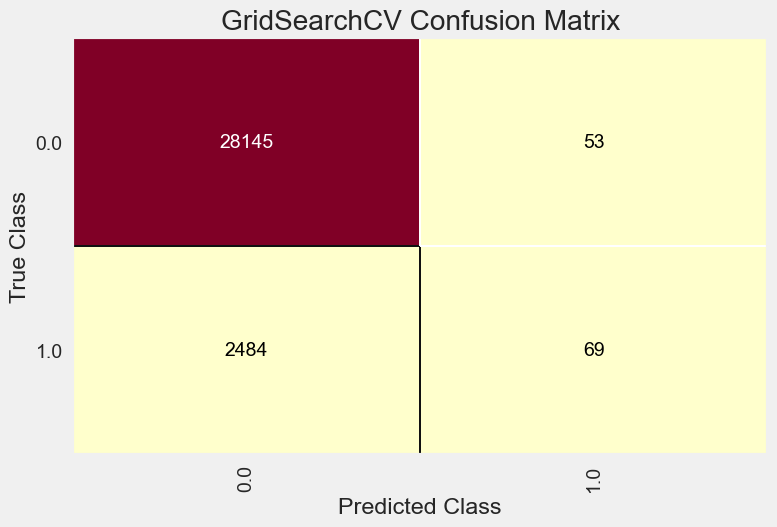

2023/04/20 05:45:40 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/20 05:47:10 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/4/9fe73c5ff65e487dbe9076211641ad1a/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/20 05:47:12 WARNING mlflow.models.model: Logging model metadata to the tracking

************************* Test scores - reg_logistic_over_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     28198
         1.0       0.17      0.68      0.27      2553

    accuracy                           0.70     30751
   macro avg       0.57      0.69      0.54     30751
weighted avg       0.89      0.70      0.77     30751



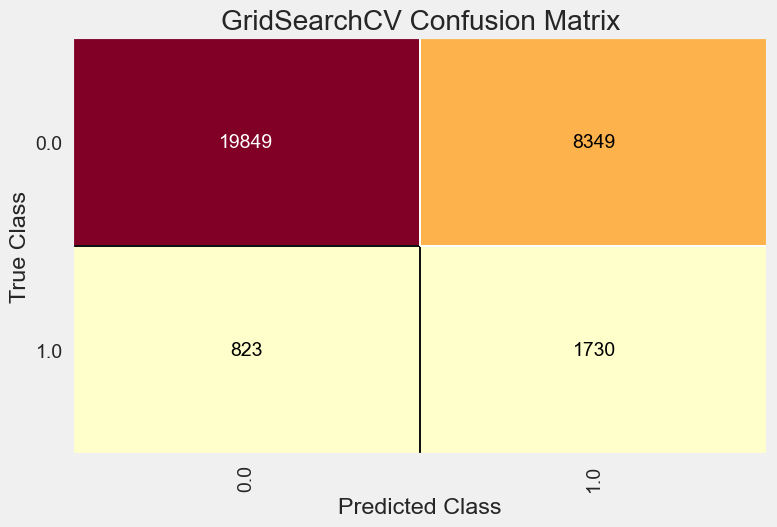

2023/04/20 05:47:13 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/20 07:07:42 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/4/c5b8dc60b7da48378931c796b89a9eee/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/20 07:07:44 WARNING mlflow.models.model: Logging model metadata to the tracking

************************* Test scores - reg_logistic_over_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82     28198
         1.0       0.17      0.63      0.27      2553

    accuracy                           0.71     30751
   macro avg       0.56      0.68      0.54     30751
weighted avg       0.89      0.71      0.77     30751



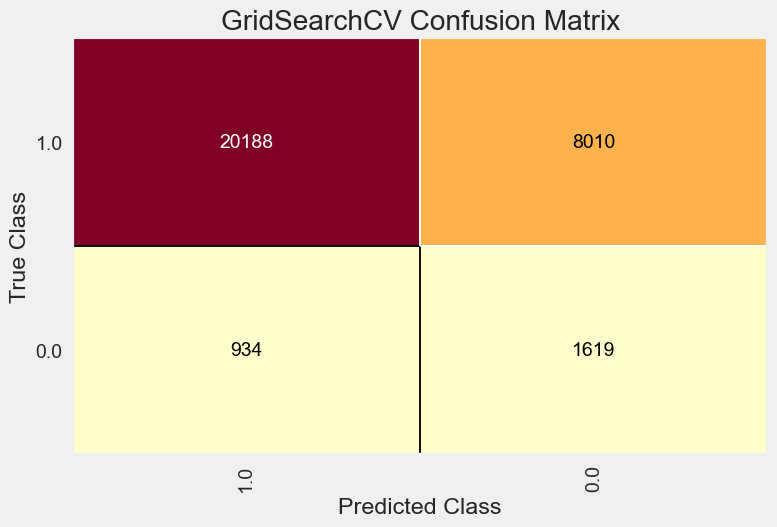

2023/04/20 07:07:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/20 07:15:18 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/4/c67ca121236a415889fc242cfd0d8811/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/20 07:15:20 WARNING mlflow.models.model: Logging model metadata to the tracking

************************* Test scores - reg_logistic_over_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.96      0.71      0.81     28198
         1.0       0.17      0.68      0.28      2553

    accuracy                           0.70     30751
   macro avg       0.57      0.69      0.54     30751
weighted avg       0.90      0.70      0.77     30751



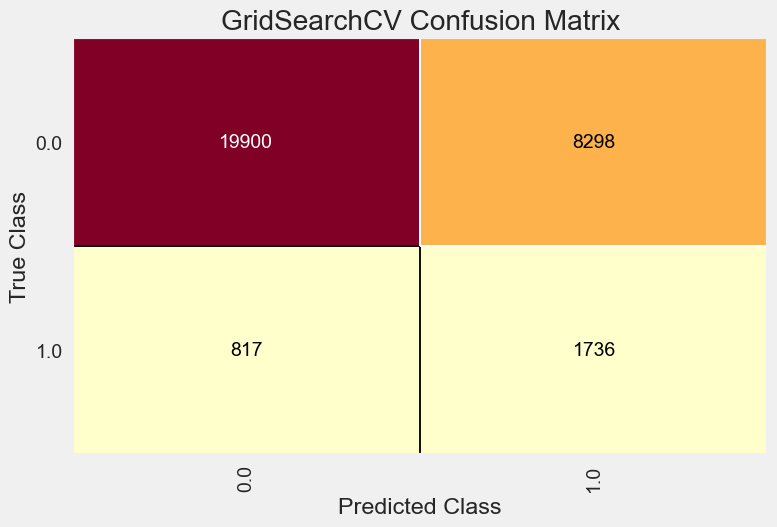

In [47]:
model_name = gs_lr
experiment_name = 'Tuned_LogisticRegression'
results.loc[len(results)], tuned_reg_log_normal  = tools.run_experiment(experiment_name, name, model_name, X_train, X_test, y_train, y_test,'LogisticRegression', 'Original')
results.loc[len(results)], tuned_reg_log_under = tools.run_experiment(experiment_name, name, model_name, X_under, X_test, y_under, y_test,'LogisticRegression', 'Undersampling')
results.loc[len(results)], tuned_reg_log_over = tools.run_experiment(experiment_name, name, model_name, X_over, X_test, y_over, y_test,'LogisticRegression', 'Oversampling')

#---------
model_name = gs_lr_balanced
results.loc[len(results)], tuned_reg_log_balanced = tools.run_experiment(experiment_name, name, model_name, X_train, X_test, y_train, y_test,'LogisticRegression', 'Balanced')


### LightGBM 

In [49]:
from lightgbm import LGBMClassifier


In [50]:
lgbm = LGBMClassifier(random_state = 42, objective = 'binary')

lgbm_balanced = LGBMClassifier(random_state = 42,
                                   objective = 'binary',
                                   class_weight = 'balanced')

params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05]
}

gs_lgbm = GridSearchCV(
    lgbm,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
)

gs_lgbm_balanced = GridSearchCV(
    lgbm_balanced,
    param_grid=params,
    scoring="roc_auc",
    cv=5, 
    return_train_score = True,
)

2023/04/20 07:15:47 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/20 07:24:14 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/1/7e3d1869e90149dea72bda4cd171e270/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/20 07:24:16 WARNING mlflow.models.model: Logging model metadata to the tracking

************************* Test scores - lightGBM_normal_data *************************
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     28198
         1.0       0.55      0.03      0.06      2553

    accuracy                           0.92     30751
   macro avg       0.74      0.52      0.51     30751
weighted avg       0.89      0.92      0.88     30751



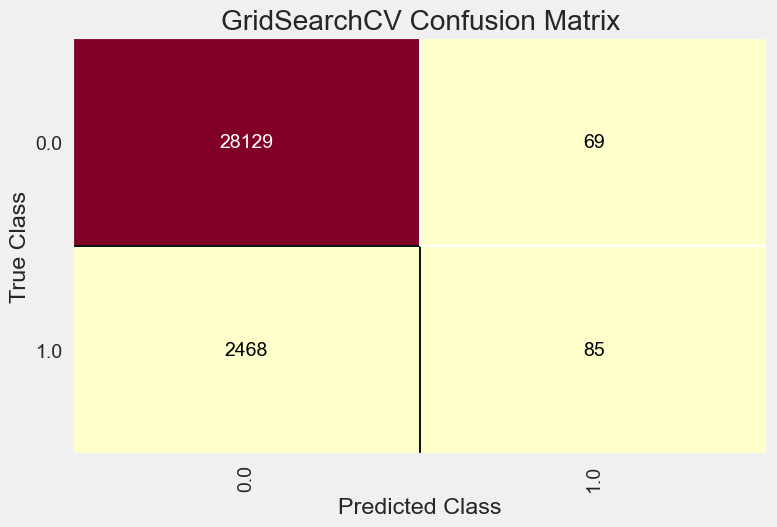

2023/04/20 07:24:17 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/20 07:26:28 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/1/6049941d233e4a74849f0e84b511d331/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/20 07:26:31 WARNING mlflow.models.model: Logging model metadata to the tracking

************************* Test scores - lightGBM_under_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     28198
         1.0       0.18      0.70      0.29      2553

    accuracy                           0.71     30751
   macro avg       0.57      0.71      0.55     30751
weighted avg       0.90      0.71      0.77     30751



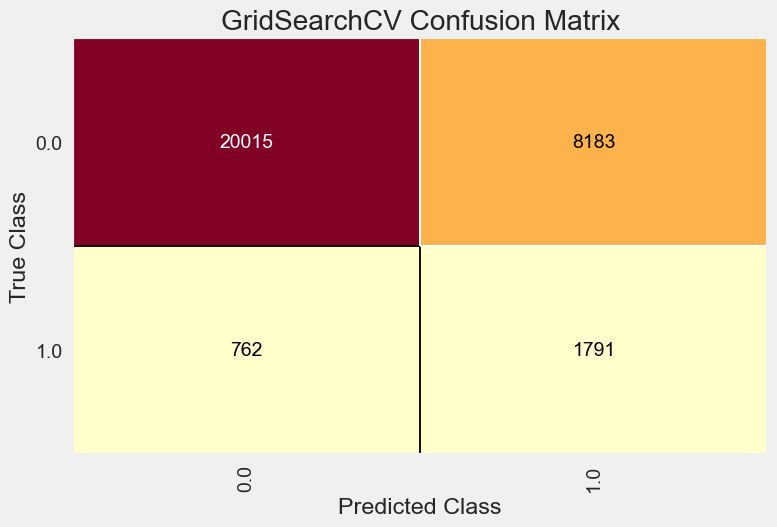

2023/04/20 07:26:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/20 07:53:34 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/1/f16433e8631747c48cd1018ca82dd58a/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/20 07:53:36 WARNING mlflow.models.model: Logging model metadata to the tracking

************************* Test scores - lightGBM_over_sampled_data *************************
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     28198
         1.0       0.33      0.01      0.02      2553

    accuracy                           0.92     30751
   macro avg       0.63      0.50      0.49     30751
weighted avg       0.87      0.92      0.88     30751



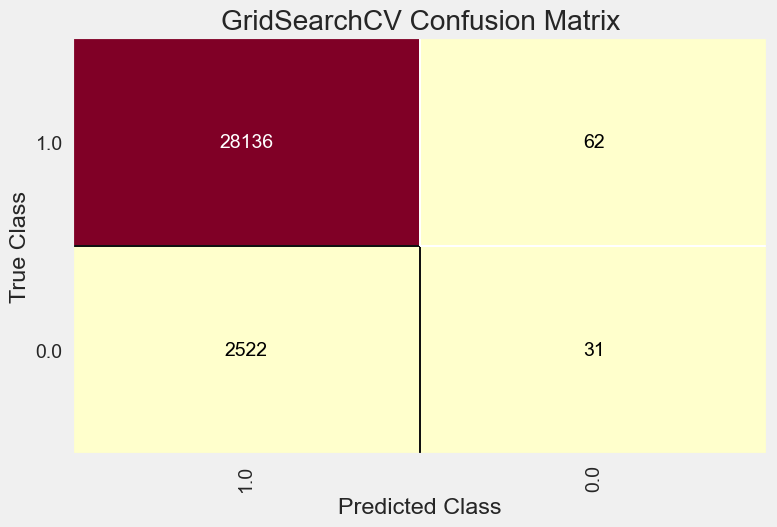

2023/04/20 07:53:37 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/20 08:18:45 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/1/4f3416e4daca4c029344b4b691e0fb81/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2023/04/20 08:18:48 WARNING mlflow.models.model: Logging model metadata to the tracking

************************* Test scores - lightGBM_balanced *************************
              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     28198
         1.0       0.19      0.68      0.29      2553

    accuracy                           0.73     30751
   macro avg       0.57      0.71      0.56     30751
weighted avg       0.90      0.73      0.79     30751



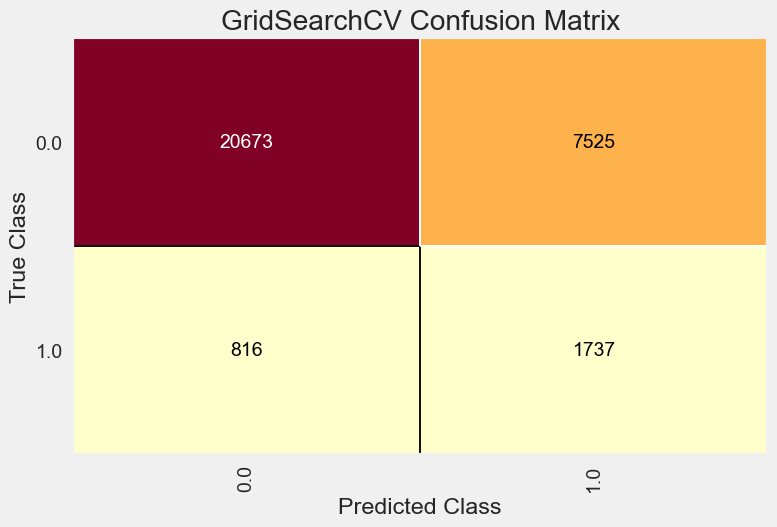

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Original,0.771,0.758,0.000000e+00
1,Baseline,Undersampling,0.775,0.758,9.536743e-07
2,Baseline,Oversampling,0.804,0.741,4.053116e-06
3,Baseline,Balanced,0.773,0.760,4.053116e-06
4,LogisticRegression,Original,0.766,0.758,0.000000e+00
5,LogisticRegression,Undersampling,0.765,0.758,0.000000e+00
6,LogisticRegression,Oversampling,0.803,0.741,4.053116e-06
7,LogisticRegression,Balanced,0.766,0.760,0.000000e+00
8,lightGBM,Normal_data,0.783,0.777,0.000000e+00
9,lightGBM,Undersampling,0.780,0.774,9.536743e-07


In [51]:
experiment_name = "lightGBM"
model_name = gs_lgbm

# run with normal data
name = "lightGBM_normal_data"
results.loc[len(results)], lgbm_normal = tools.run_experiment(experiment_name, name, model_name, X_train, X_test, y_train, y_test, 'lightGBM', 'Normal_data')

# run with undersampled data
name = "lightGBM_under_sampled_data"
results.loc[len(results)], lgbm_under = tools.run_experiment(experiment_name, name, model_name, X_under, X_test, y_under, y_test, 'lightGBM', 'Undersampling')

# run with oversampled data
name = "lightGBM_over_sampled_data"
results.loc[len(results)], lgbm_over = tools.run_experiment(experiment_name, name, model_name, X_over, X_test, y_over, y_test, 'lightGBM', 'Oversampling')


model_name = gs_lgbm_balanced
name = "lightGBM_balanced"
results.loc[len(results)], lgbm_balanced = tools.run_experiment(experiment_name, name, model_name, X_train, X_test, y_train, y_test, 'lightGBM', 'Balanced')


results

In [54]:
gc.collect()

15564

In [56]:
import keras
import mlflow.keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical


from mlflow.models.signature import infer_signature
signature = infer_signature(X_over, y_over)

2023/04/17 13:24:02 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2023/04/17 13:24:02 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: cannot import name '__version__' from partially initialized module 'keras' (most likely due to a circular import) (/Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/.venv/lib/python3.9/site-packages/keras/__init__.py)


In [69]:
mlflow.set_experiment("neural_classification")


def model_training(X_train, X_test, y_train, y_test):
    mlflow.keras.autolog()
    print("\n", "-" * 35, " Model training", "-" * 35, "\n")
    print("X_train shape :", X_train.shape)
    print("X_test shape :", X_test.shape, "\n")
    # Train the model
    print("Selected model : Neural network", "\n")
    # one hot encode outputs
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    # get the number of variables that included in the feature vector
    num_var = X_test.shape[1]
    # get the number of classes
    num_classes = y_test.shape[1]
    # prepare the model
    model = Sequential()
    model.add(Dense(6, activation="relu", input_shape=(num_var,)))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    # Compile the model
    model.compile(optimizer='sgd',
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.AUC()])
   
    # fit the model
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)
    # Predictions
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    # evaluate the model
    # print("\n", "-" * 35, " Model evaluation", "-" * 35, "\n")
    # print(classification_report(y_test, pred_test))
    return model

In [67]:
results

,Algorithm,Balancing_method,AUC,AUC_test,Time
0,Baseline,Original,0.771,0.758,0.000000e+00
1,Baseline,Undersampling,0.775,0.758,0.000000e+00
2,Baseline,Oversampling,0.804,0.741,0.000000e+00
3,Baseline,Balanced,0.773,0.760,9.536743e-07
4,LogisticRegression,Original,0.766,0.758,0.000000e+00
5,LogisticRegression,Undersampling,0.765,0.758,0.000000e+00
6,LogisticRegression,Oversampling,0.803,0.741,7.152557e-07
7,LogisticRegression,Balanced,0.766,0.760,0.000000e+00
8,lightGBM,Normal_data,0.783,0.777,9.536743e-07
9,lightGBM,Undersampling,0.780,0.774,0.000000e+00


In [71]:
# 

# from mlflow.models.signature import infer_signature
# signature = infer_signature(X_over, y_over)
# with mlflow.start_run(run_name="over_sampled_data"):
#     model = model_training(X_over, X_test, y_over, y_test)
#     #resultsss = model.evaluate(X_test, y_test, batch_size=128)
#     #print("test loss, test acc:", results)
    
#     auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
#     auc


# fit the model

In [72]:
# from mlflow.models.signature import infer_signature
# signature = infer_signature(X_over, y_over)
# with mlflow.start_run(run_name="over_sampled_data"):
#     model = model_training(X_over, X_test, y_over, y_test)
#     results = model.evaluate(X_test, y_test, batch_size=128)
#     print("test loss, test acc:", results)

### Custom score


In [62]:
from sklearn.feature_selection import RFECV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

In [63]:
def custom_score(y_true, y_pred) :
    '''
        Cost function to minimize the risk for the
        loaning firm.
    
        Parameters
        --------
        - y_true : pandas dataframe
                   The true values of the target
        - y_pred : pandas dataframe
                   The predicted values for the target
            
        Returns
        --------
        - score : float
                  The score for the prediction
    '''

    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()
    N = TN + FP    # total negatives cases
    P = TP + FN    # total positives cases
    
    # Setting the bank's gain and loss for each case
    FN_value = -10   # The loan is granted but the customer defaults : the bank loses money (Type-II Error)
    TN_value = 1     # The loan is reimbursed : the bank makes money
    TP_value = 0     # The loan is (rightly) refused : the bank neither wins nor loses money
    FP_value = -1    # Loan is refused by mistake : the bank loses money it could have made, 
                     # but does not actually lose any money (Type-I Error)

    # calculate total gains
    gain = TP*TP_value + TN*TN_value + FP*FP_value + FN*FN_value
    
    # best score : all observations are correctly predicted
    best = N*TN_value + P*TP_value 

    # baseline : all observations are predicted = 0
    baseline = N*TN_value + P*FN_value 
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain - baseline) / (best - baseline)
    
    return score

In [64]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
}

In [65]:
def objective(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda']
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [66]:

%%time
best = fmin(fn=objective, space=space, max_evals=10, algo=tpe.suggest)

100%|██████████| 10/10 [36:41<00:00, 220.12s/trial, best loss: 0.9696210488505748]
CPU times: user 1h 16min 31s, sys: 5min 28s, total: 1h 21min 59s
Wall time: 36min 41s


In [67]:
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
signature = infer_signature(X_train, y_train)

In [68]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    class_weight = 'balanced',)

lgbm.fit(X_train, y_train)

2023/04/20 09:34:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e828b1cc8d9842dda2a835c713a36718', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow
2023/04/20 09:34:56 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed, possibly due older server version. The model artifacts have been logged successfully under /Users/alhassanneahmedap59_cb/git/perso/Projects/loan-credit-scoring/notebooks/mlruns/1/e828b1cc8d9842dda2a835c713a36718/artifacts. In addition to exporting model artifacts, MLflow clients 1.7.0 and above attempt to record model metadata to the tracking store. If logging to a mlflow server via REST, consider upgrading the server version to MLflow 1.7.0 or above. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


CPU times: user 2min 5s, sys: 7.24 s, total: 2min 13s
Wall time: 39.7 s


LGBMClassifier(class_weight='balanced', colsample_bytree=0.7855484984381862,
               learning_rate=0.02807609096592543, max_depth=5, n_estimators=600,
               reg_lambda=14.553152252426713, subsample=0.6794980328561607)

In [69]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.778436


In [72]:
#Sauvegarde du modèle
pickle.dump(lgbm, open("../app/models/model_opti.pkl", "wb"))

### Explainability

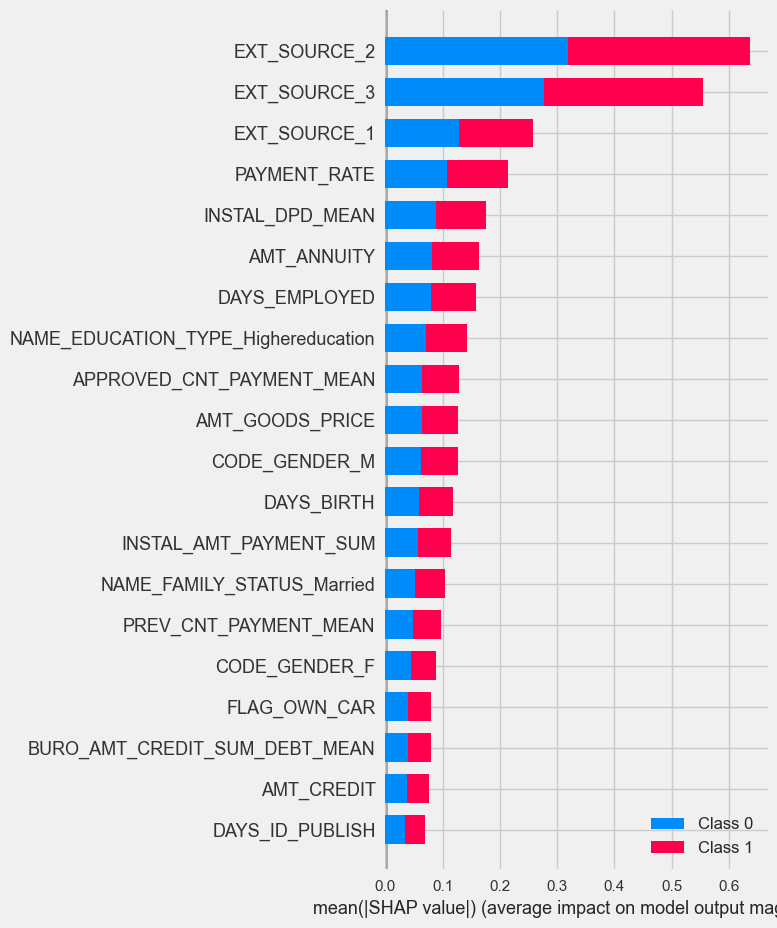

In [97]:
import shap

# DF, based on which importance is checked
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_importance)


# Plot summary_plot
shap.summary_plot(shap_values, X_importance)

In [98]:
%time 
shap_values = shap.TreeExplainer(lgbm).shap_values(X_test)

CPU times: user 1 µs, sys: 3 µs, total: 4 µs
Wall time: 11 µs


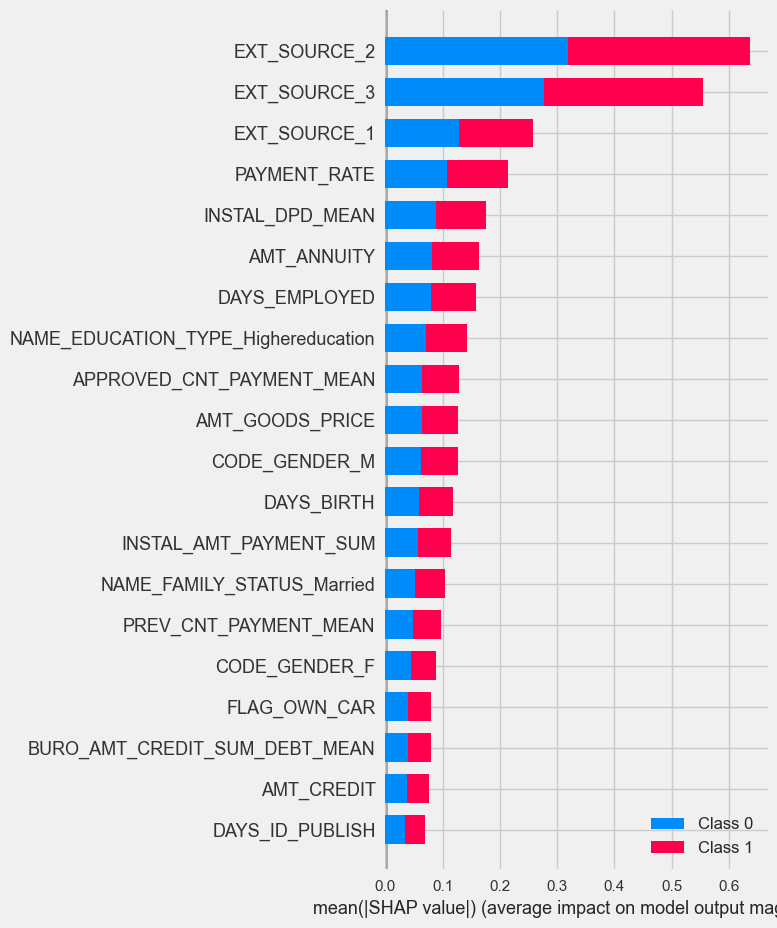

In [99]:
shap.summary_plot(shap_values, X_test)

100%|===================| 276725/276760 [52:21<00:00]        

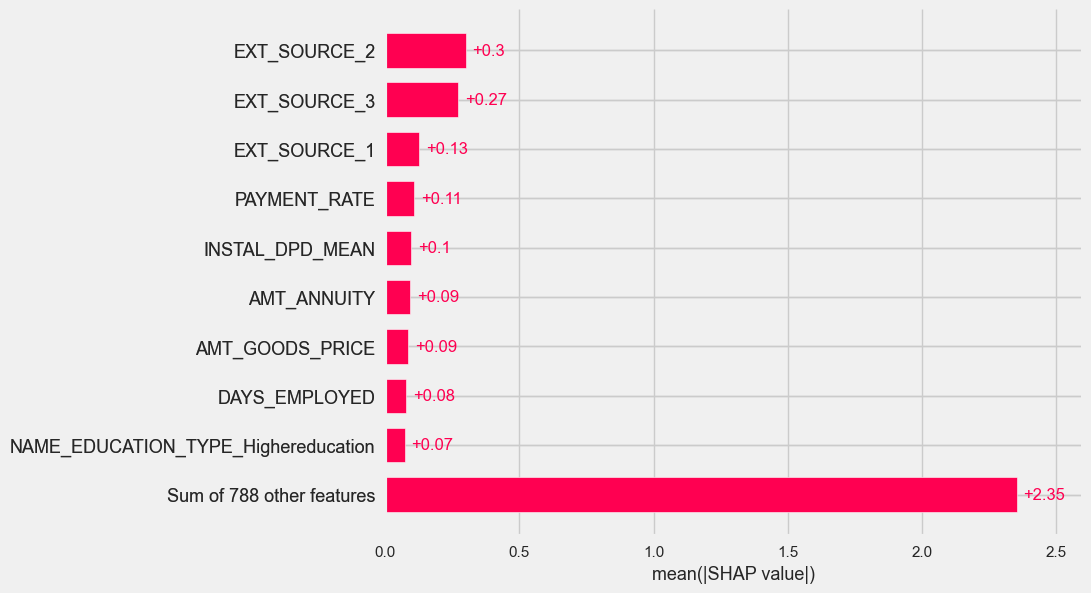

In [100]:
# compute SHAP values

explainer = shap.Explainer(lgbm, X_train)
shap_values = explainer(X_train, check_additivity=False)
shap.plots.bar(shap_values)

In [ ]:
# Save optimal model
pickle.dump(lgbm, open("../app/models/model_opti.pkl", "wb"))